<a href="https://colab.research.google.com/github/MohammedKhrishi/renewable-energy-data-analysis/blob/main/Model_stacking_for_renewable_energy_analysis_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn .svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Conv1D, ReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [4]:
# loading dataset for further analysis
df=pd.read_csv("/content/Horizontal Photovoltaic Output Power.csv")

In [ ]:
# EDA analysis and get to know our dataset columns and features
df.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

In [6]:
df.shape

(21045, 17)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Date,21045.0,2.017720e+07,4.579585e+03,2.017052e+07,2.017111e+07,2.018032e+07,2.018062e+07,2.018100e+07
Time,21045.0,1.267484e+03,1.676028e+02,1.000000e+03,1.100000e+03,1.300000e+03,1.400000e+03,1.545000e+03
Latitude,21045.0,3.821382e+01,6.323761e+00,2.089000e+01,3.816000e+01,3.895000e+01,4.115000e+01,4.752000e+01
Longitude,21045.0,-1.085937e+02,1.636413e+01,-1.564400e+02,-1.172600e+02,-1.111800e+02,-1.047100e+02,-8.011000e+01
Altitude,21045.0,7.988437e+02,7.706818e+02,1.000000e+00,2.000000e+00,4.580000e+02,1.370000e+03,1.947000e+03
YRMODAHRMI,21045.0,2.017718e+11,4.579846e+07,2.017050e+11,2.017110e+11,2.018030e+11,2.018060e+11,2.018100e+11
Month,21045.0,6.565883e+00,2.983958e+00,1.000000e+00,4.000000e+00,7.000000e+00,9.000000e+00,1.200000e+01
Hour,21045.0,1.262785e+01,1.672952e+00,1.000000e+01,1.100000e+01,1.300000e+01,1.400000e+01,1.500000e+01
Humidity,21045.0,3.712194e+01,2.382301e+01,0.000000e+00,1.752930e+01,3.312378e+01,5.259399e+01,9.998779e+01
AmbientTemp,21045.0,2.928512e+01,1.236682e+01,-1.998177e+01,2.191528e+01,3.028915e+01,3.747467e+01,6.573837e+01


In [ ]:
# trying to understand our dataset realtionships through pairplot from sns library
sns.pairplot(df)

<ipython-input-7-e85a9a0568d0>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr();


Text(0.5, 1.0, 'Correlation analysis')

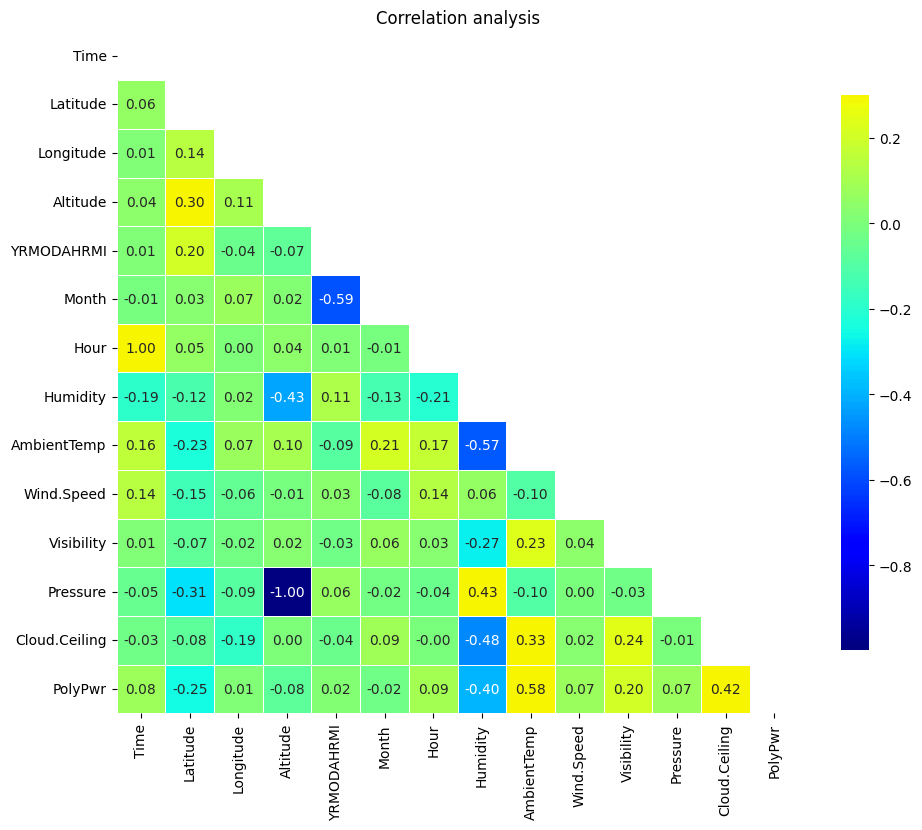

In [7]:
# doing correlatio analysis for specific number of features
df_correlation = df[['Location', 'Time', 'Latitude', 'Longitude', 'Altitude',
              'YRMODAHRMI', 'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr();
mask = np.triu(np.ones_like(df_correlation, dtype=bool))
# plotting the correlation results using seaborn heatmap library
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_correlation, mask=mask, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis')

In [12]:
df["Location"]

0        Camp Murray
1        Camp Murray
2        Camp Murray
3        Camp Murray
4        Camp Murray
            ...     
21040          USAFA
21041          USAFA
21042          USAFA
21043          USAFA
21044          USAFA
Name: Location, Length: 21045, dtype: object

In [14]:
df["Location"].value_counts()

Travis         2746
Peterson       2640
USAFA          2573
Hill Weber     2384
March AFB      2204
JDMT           1779
Malmstrom      1517
Grissom        1487
Camp Murray    1113
Kahului         941
Offutt          881
MNANG           780
Name: Location, dtype: int64

In [22]:
df.groupby(["Location"])[['AmbientTemp','PolyPwr']].mean()

,AmbientTemp,PolyPwr
Location,,
Camp Murray,30.450185,10.777723
Grissom,25.569657,9.426174
Hill Weber,30.022489,14.437151
JDMT,36.037962,18.574124
Kahului,29.211252,15.222645
MNANG,21.628888,9.996263
Malmstrom,15.766080,9.886024
March AFB,31.969279,13.761134
Offutt,28.680158,13.895667


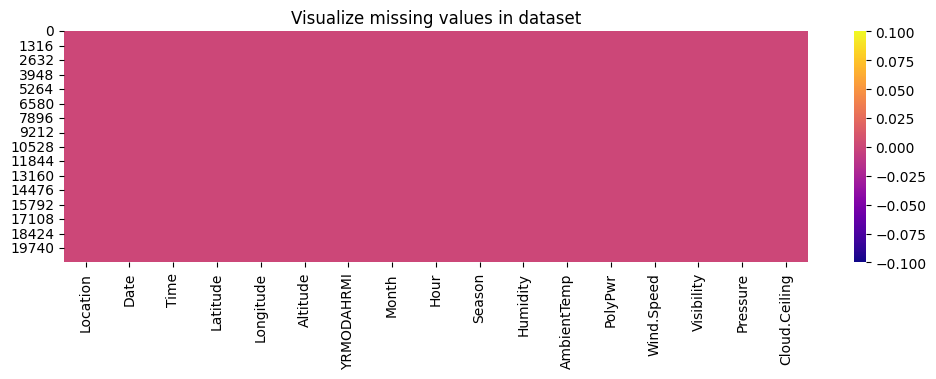

In [8]:
# checking for NaN values and trying to process all missing values
plt.figure(figsize=(12, 3))
sns.heatmap(df.isnull(), cmap='plasma');
plt.title('Visualize missing values in dataset');

In [9]:
# Encode location data for ML models using get_dummies module
df_with_location_encoded = pd.get_dummies(df, columns=['Location'], drop_first=True)
df_with_loc_season_encoded = pd.get_dummies(df_with_location_encoded, columns=['Season'], drop_first=True)

# doing some analysis for cyclic features engineering rather than ordinary time specified in dataset
min_hour_interest = 10
max_hour_interest= 15

df_with_loc_season_encoded['delta_hr']= df_with_loc_season_encoded.Hour - min_hour_interest;

df_with_loc_season_encoded['sine_mon']= np.sin((df_with_loc_season_encoded.Month - 1)*np.pi/11)
df_with_loc_season_encoded['cos_mon']= np.cos((df_with_loc_season_encoded.Month - 1)*np.pi/11)
df_with_loc_season_encoded['sine_hr']= np.sin((df_with_loc_season_encoded.delta_hr*np.pi/(max_hour_interest - min_hour_interest)))
df_with_loc_season_encoded['cos_hr']= np.cos((df_with_loc_season_encoded.delta_hr*np.pi/(max_hour_interest - min_hour_interest)))


In [28]:
# It is seen that after reengineering features, we come up with 34 features including all encoded newly created features
df_with_loc_season_encoded.head(20)

,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Humidity,AmbientTemp,...,Location_Travis,Location_USAFA,Season_Spring,Season_Summer,Season_Winter,delta_hr,sine_mon,cos_mon,sine_hr,cos_hr
0,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,81.71997,12.86919,...,0,0,0,0,1,1,5.665539e-16,-1.0,5.877853e-01,0.809017
1,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,96.64917,9.66415,...,0,0,0,0,1,3,5.665539e-16,-1.0,9.510565e-01,-0.309017
2,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,93.61572,15.44983,...,0,0,0,0,1,3,5.665539e-16,-1.0,9.510565e-01,-0.309017
3,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,77.21558,10.36659,...,0,0,0,0,1,2,5.665539e-16,-1.0,9.510565e-01,0.309017
4,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,54.80347,16.85471,...,0,0,0,0,1,4,5.665539e-16,-1.0,5.877853e-01,-0.809017
5,20171204,1430,47.11,-122.57,84,2.017120e+11,12,14,47.10083,18.12363,...,0,0,0,0,1,4,5.665539e-16,-1.0,5.877853e-01,-0.809017
6,20171205,1115,47.11,-122.57,84,2.017120e+11,12,11,43.55469,19.41269,...,0,0,0,0,1,1,5.665539e-16,-1.0,5.877853e-01,0.809017
7,20171205,1200,47.11,-122.57,84,2.017120e+11,12,12,30.56641,23.90930,...,0,0,0,0,1,2,5.665539e-16,-1.0,9.510565e-01,0.309017
8,20171205,1300,47.11,-122.57,84,2.017120e+11,12,13,17.90771,32.32346,...,0,0,0,0,1,3,5.665539e-16,-1.0,9.510565e-01,-0.309017
9,20171205,1400,47.11,-122.57,84,2.017120e+11,12,14,14.40430,35.41267,...,0,0,0,0,1,4,5.665539e-16,-1.0,5.877853e-01,-0.809017


In [10]:
# for modelling purpose, selected columns will be only processed for further analysis for specific location
selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location_Grissom',
                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                     'Location_USAFA','Season_Spring', 'Season_Summer', 'Season_Winter',
                     'sine_mon', 'cos_mon', 'sine_mon', 'cos_hr']

df_desired = df_with_loc_season_encoded[selected_columns].reset_index(drop=True)
target_label = 'PolyPwr';
input_feat = list(set(selected_columns).difference(set([target_label])))
df_X = df_desired[input_feat].reset_index(drop=True)
df_Y = df_desired[target_label]
print(df_Y.shape)
print(df_X.shape)
# splitting dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42);
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(21045,)
(21045, 25)
(16836, 25)
(16836,)
(4209, 25)
(4209,)


In [11]:
# Neural network configuration model setup
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Conv1D, ReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [12]:
# building our model function using Squential Keras API
def dl_model(n_units1, n_units2, n_units3, act1, act2, act3, ker_init, lr, dr0, dr1, dl_loss):
    model = Sequential()
    model.add(Dense(n_units1, activation=act1, kernel_initializer=ker_init, input_dim=X_train.shape[1]))
    # model.add(Dense(n_units1, activation=act1, kernel_initializer=ker_init))
    model.add(Dropout(dr0))
    model.add(Dense(n_units2, activation=act2, kernel_initializer=ker_init))
    model.add(Dropout(dr1))
    model.add(Dense(n_units3, activation=act3, kernel_initializer=ker_init))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=[r_squared, tf.keras.metrics.mean_squared_error], loss=dl_loss)
    return model

In [13]:
def custom_loss(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return SS_res/(SS_tot+K.epsilon())

# r_squared metric for deep learning model implementation
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))

# Create list of each hyper-param to tune
n_units1_list = [40*x for x in range(3, 10)]
n_units2_list = [40*x for x in range(3, 10)]
n_units3_list = [40*x for x in range(3, 10)]

act1_list = ['relu', 'tanh']
act2_list = ['relu', 'tanh']
act3_list = ['relu', 'tanh']

ker_init_list = ['glorot_normal', 'glorot_uniform']

learning_rate_list = [round(np.power(0.1, x/3), 5) for x in range(8, 11)]

dl_loss_list = [custom_loss, 'mean_squared_error']

batch_size_list = [600]

epochs_list = [100]

dr0_list = [0.1, 0.2, 0.3]
dr1_list = [0.1, 0.2, 0.3]

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [24]:
!pip install -qq -e git+https://github.com/adriangb/scikeras.git#egg=scikeras

dl_grid = {'kr__n_units1':n_units1_list,
            'kr__n_units2':n_units2_list,
            'kr__n_units3':n_units3_list,
            'kr__act1':act1_list,
            'kr__act2':act2_list,
            'kr__act3':act3_list,
            'kr__ker_init':ker_init_list,
            'kr__lr':learning_rate_list,
            'kr__dl_loss':dl_loss_list,
            'kr__batch_size':batch_size_list,
            'kr__epochs':epochs_list,
            'kr__dr0':dr0_list,
            'kr__dr1':dr1_list,
            'kr__callbacks':[early_stopping_callback],
            'kr__validation_split':[0.1]}

rf_grid = {'n_estimators': n_estimators_list,
           'max_features': max_features_list,
           'max_depth': max_depth_list,
           'min_samples_split': min_samples_split_list,
           'min_samples_leaf': min_samples_leaf_list,
           'bootstrap': bootstrap_list}


knn_grid = {'knn__n_neighbors':n_neighbors_list,
             'knn__weights':weights_list,
             'knn__algorithm':algorithm_list,
             'knn__leaf_size':leaf_size_list,
             'knn__p':p_list}

lgbm_grid = {'num_leaves':n_leaves_list,
             'max_depth':max_depth_list,
             'learning_rate':learning_rate_list,
             'n_estimators':n_estimators_list,
             'feature_fraction':feature_fraction_list,
             'objective':objective_list}


# using PIPELINE for efficient data flow and analysis
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('kr', KerasRegressor(build_fn=dl_model)))
pipeline = Pipeline(estimators)


# Scale training data and confiure pipline for knn model
estimators = []
estimators.append(('minmax', MinMaxScaler()))
estimators.append(('knn', KNeighborsRegressor()))
knn_pipeline = Pipeline(estimators)


  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for scikeras (pyproject.toml) ... done


<ipython-input-24-c64e873c0f4d>:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('kr', KerasRegressor(build_fn=dl_model)))


In [25]:
dl_best_params = {'kr__n_units3':320,
                    'kr__n_units2':240,
                    'kr__n_units1':280,
                    'kr__lr':0.001,
                    'kr__ker_init':tf.keras.initializers.GlorotUniform(seed=32),
                    'kr__epochs':70,
                    'kr__dr1':0.1,
                    'kr__dr0':0.1,
                    'kr__dl_loss':custom_loss,
                    'kr__batch_size':600,
                    'kr__act3':'tanh',
                    'kr__act2':'relu',
                    'kr__act1':'relu',
                    'kr__verbose':0}

rf_best_params={'n_estimators': 1800,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 20,
    'bootstrap': True}

knn_best_params={'knn__weights': 'distance',
    'knn__p': 2,
    'knn__n_neighbors': 15,
    'knn__leaf_size': 30,
    'knn__algorithm': 'ball_tree'}

lgbm_best_params={'objective': 'rmse',
    'num_leaves': 1400,
    'n_estimators': 900,
    'max_depth': 11,
    'learning_rate': 0.008,
    'feature_fraction': 0.6}


dl_model = pipeline.set_params(**dl_best_params)
rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
knn_model = knn_pipeline.set_params(**knn_best_params)
lgbm_model = LGBMRegressor(**lgbm_best_params)

In [26]:
dl_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)


Pipeline(steps=[('standardize', StandardScaler()),
                ('kr',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x787e4575f520>)])

In [27]:
# checking our model for predictions on test data
y_pred = dl_model.predict(X_test)

In [28]:
# Explained variance
print(explained_variance_score(y_test.ravel(), y_pred))
# R2 score
print(r2_score(y_test.ravel(), y_pred))
# Mean absolute error
print(mean_absolute_error(y_test.ravel(), y_pred))
# Root mean square error
print(np.sqrt(mean_squared_error(y_test.ravel(), y_pred)))
print(mean_absolute_percentage_error(y_test.ravel(), y_pred)*100)

0.6636595533285929
0.662870094560389
2.7194803725397123
4.138401901814689
50.0192562858794


In [ ]:
# feature important analysis
rf_model.feature_importances_
# Calculate scaled feature importance as a percentage
feat_imp_score = (rf_model.feature_importances_/max(rf_model.feature_importances_)*100).tolist()
feature_ranking_with_score = dict(sorted(zip(feat_imp_score, input_feat), reverse=True))

feature_ranking_with_score



In [ ]:
# define meta-learner model
base_model = list()
base_model.append(('dl', dl_model))
base_model.append(('lgbm', lgbm_model))
base_model.append(('rf', rf_model))
base_model.append(('knn', knn_model))

base1 = LinearRegression()
# using StackingRegressor for gathering all models
stacked_model = StackingRegressor(estimators=base_model, final_estimator=base1, cv=4, passthrough=True)

# Fit the model on the training data
stacked_model.fit(X_train, y_train)


In [ ]:
# making predictions on test data
y_pred = stacked_model.predict(X_test)

# Evaluate model performance
print(explained_variance_score(y_test.ravel(), y_pred))
# R2 score
print(r2_score(y_test.ravel(), y_pred))
# Mean absolute error
print(mean_absolute_error(y_test.ravel(), y_pred))
# Root mean square error
print(np.sqrt(mean_squared_error(y_test.ravel(), y_pred)))
print(mean_absolute_percentage_error(y_test.ravel(), y_pred)*100)